In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
# from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

## Loading data

In [2]:
bj_gdp=gpd.read_file('data/shapes/09m.shp')

### We only keep the CVE Municipalities (Alcaldies) of our interest, in this Case '014' is Benito Juarez

In [3]:
bj_gdp=bj_gdp[bj_gdp['CVE_MUN']=='014']

<AxesSubplot:>

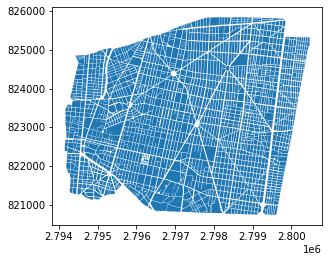

In [4]:
%matplotlib inline
bj_gdp.plot()

### Cleaning prices and finding lat and long

In [ ]:
# data=pd.read_csv(path+'TeamProject/clean_data.csv')

In [ ]:
# data.head()

In [ ]:
# data['price']=[int(i.replace(',','')) for i in data['price']]

In [ ]:
# data['lat']=''
# data['lng']=''

# for i in range(data.shape[0]):
    
#     # Build the endpoint URL
#     target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={data["adress"][i]}&key={gkey}'

#     geo_data = requests.get(target_url).json()

#     data['lat'][i] = geo_data["results"][0]["geometry"]["location"]["lat"]
#     data['lng'][i] = geo_data["results"][0]["geometry"]["location"]["lng"]

In [5]:
# data.to_csv('houses_gpd.csv',index=False)
data=pd.read_csv('data/BJCoords.csv')

In [6]:
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
data['price']=[int(i.replace(',','')) for i in data['price']]
data['price_m2']=data['price']/data['m2']

In [7]:
data[['status','price_m2','m2']].groupby('status',as_index=False).mean()

,status,price_m2,m2
0,Casa en venta,211181.301817,296.728175


In [8]:
pd.options.display.float_format = '{:.2f}'.format
data[['price','price_m2','m2']].describe()

,price,price_m2,m2
count,1008.00,1008.00,1008.00
mean,11165985.33,211181.30,296.73
std,11964025.55,2106521.89,147.34
min,190000.00,567.16,1.00
25%,6047250.00,26666.67,200.00
50%,10000000.00,36956.52,265.50
75%,13500000.00,45384.96,360.00
max,246050000.00,39700000.00,1200.00


### Removing outliers in price by square meter.

We scrapped the data from metroscubicos.com, they also provide some metadata analysis showing maximum and minimum of prices.
You can find the info [here](https://www.metroscubicos.com/precios/distrito-federal/benito-juarez). Using these maximum and minimum we dropped all the prices outside this range.

In [9]:
# Values from: https://www.metroscubicos.com/precios/distrito-federal/benito-juarez
min_m2=11378.88
max_m2=69258.41

data=data[(data['price_m2']>min_m2)&(data['price_m2']<max_m2)]
data[['price','price_m2','m2']].describe()

,price,price_m2,m2
count,870.00,870.00,870.00
mean,11539520.18,38515.81,300.95
std,7105905.94,12106.24,144.93
min,1070388.00,11850.00,70.00
25%,7412500.00,30263.16,213.00
50%,10750000.00,38210.17,273.50
75%,13846718.75,45882.35,360.00
max,78800000.00,66666.67,1200.00


### Price distribution plot by $m^2$ in Benito Juarez

The distribution showed below is consistent with the data found on internet about $price/m^2$ in the Alcaldia Benito Juarez.

(array([ 37.,  50.,  86., 123., 172., 158.,  90.,  70.,  57.,  27.]),
 array([11850.        , 17331.66666667, 22813.33333333, 28295.        ,
        33776.66666667, 39258.33333333, 44740.        , 50221.66666667,
        55703.33333333, 61185.        , 66666.66666667]),
 <BarContainer object of 10 artists>)

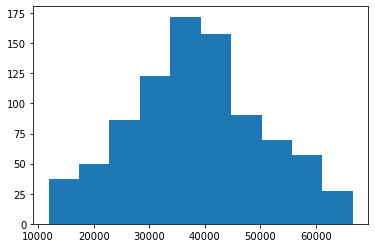

In [10]:
plt.hist(data['price_m2'])

## Making lat & lon as geometry

In order to merge the census data with the data about prices we need to do a spatial join. In the next step we convert the pandas dataframe into geopandas in order to make the spatial join.

In [11]:
geometry =[Point(xy) for xy in zip(data['long'],data['lat'])]
crs={'init':'epsg:4326'}
points_gpd=gpd.GeoDataFrame(data,crs=crs,geometry=geometry)

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### We have to check if the Coordinate reference system (CRS) of both geodataframes are equal, if not, we have to set the equal

In [12]:
points_gpd.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
bj_gdp.crs

<Projected CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["MEXICO_ITRF_ ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- E[east]: Easting (Meter)
- N[north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS_1980
- Prime Meridian: Greenwich

The CRS were different, we changed the Benito Juarez crs to match the one in prices geopanda as shown below.

In [14]:
# Changing CRS in Benito Juarez
bj_gdp.to_crs('epsg:4326',inplace=True)

### Spatial join

In [15]:
points_gdp2=sjoin(points_gpd,bj_gdp,how='left')

<ipython-input-15-50ef5b8487da>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  points_gdp2=sjoin(points_gpd,bj_gdp,how='left')


We need to find if google API found a lat long point out of Benito Juarez, to do that we need to find the extreme points in Benito Juarez polygons.

In [16]:
# Finding if there are points outside the Alcaldia
bounderies=bj_gdp.geometry.bounds

In [17]:
list(bounderies)

['minx', 'miny', 'maxx', 'maxy']

In [18]:
min_x=bounderies['minx'].min()
min_y=bounderies['miny'].min()
max_x=bounderies['maxx'].max()
max_y=bounderies['maxy'].max()


In [19]:
cl=(~points_gdp2['CVE_ENT'].isna())

points_gdp2=points_gdp2[cl]

 Creating **id** variable to merge with polygons.

In [20]:
points_gdp2['id']=points_gdp2['CVE_MUN']+points_gdp2['CVE_LOC']+points_gdp2['CVE_AGEB']+points_gdp2['CVE_MZA']

In [21]:
cl=(points_gdp2['lat']>max_y)|(points_gdp2['lat']<min_y)|(points_gdp2['long']>max_x)|(points_gdp2['long']<min_x)
points_gdp2=points_gdp2[~cl]

### These are the houses lat and long in Benito Juarez polygons.

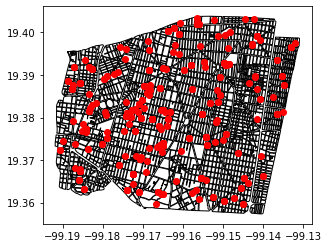

In [22]:
ax = bj_gdp.plot(color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
points_gdp2.plot(ax=ax, color='red')

plt.show()

## Computing $Price/m^2$ in Benito Juarez

In [23]:
points_gdp2['price_m2']=points_gdp2['price']/points_gdp2['m2']

### Loading Alcaldias attribures

In [24]:
attr=pd.read_csv('variables_and_percents/BJ_10_20.csv')

The next function helped us to set the format in key variables to generate **id** variable.

In [25]:
def zero_plus(item,digits):
    i=str(item)
    zeros=digits-len(i)
    return zeros*'0'+i

In [26]:
attr['mun']=[zero_plus(i,3) for i in attr['mun']]
attr['loc']=[zero_plus(i,4) for i in attr['loc']]
attr['ageb']=[zero_plus(i,4) for i in attr['ageb']]
attr['mza']=[zero_plus(i,3) for i in attr['mza']]
attr['id']='014'+attr['loc']+attr['ageb']+attr['mza']

### Merge metros cubicos attributes and INEGI attributes and grouping by mean in $price/m^2$

In [27]:
price_mz=points_gdp2[['id','price_m2']].groupby(['id'],as_index=False).mean()

In [28]:
data=price_mz[['id','price_m2']].merge(attr,on='id',how='left')

In [29]:
data.drop(columns=['nom_ent',
                   'Unnamed: 0',
                   'nom_ent',
                   'mun',
                   'loc',
                   'ageb',
                   'mza'],inplace=True)

### Exporting data to import in the model 

In [30]:
data.to_csv('data/BJ_to_model.csv',index=False)